In [1]:
# This is my first deep neural network 

In [2]:
import sys
sys.executable              #interpreter used

In [3]:
from platform import python_version
print(python_version())     #python version

In [ ]:
#to install tensorflow framework: type in your terminal:
pip install tensorflow==1.15  #CPU

In [4]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)


In [5]:
print(tf.__version__)   #tensorflow version

1.15.0


In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
#This will print whether your tensorflow is using a CPU or a GPU backend.

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [7]:
from tf_utils import*
# this tf_utils.py contains functions for the model: load_dataset, random_mini_batches, convert_to_one_hot, predict


#  Dataset





- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.



In [8]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [9]:
# let's check the shape of our datasets 
print("Shape of X_train: ", X_train_orig.shape)
print("Shape of Y_train: ", Y_train_orig.shape)
print("Shape of X_test:  ",X_test_orig.shape)
print("Shape of Y_test:  ",Y_test_orig.shape)


Shape of X_train:  (1080, 64, 64, 3)
Shape of Y_train:  (1, 1080)
Shape of X_test:   (120, 64, 64, 3)
Shape of Y_test:   (1, 120)


y = 5


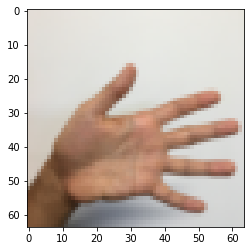

In [10]:
# let's visualize our first training example
plt.imshow(X_train_orig[0])
print ("y = " + str(np.squeeze(Y_train_orig[:, 0])))

In [11]:
# flatten the image dataset, then normalize it by dividing by 255, convert label to a one-hot vector

# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


# Model
**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*

-create placeholders for X and Y. This will allow you to later pass your training data in when you run your session

In [12]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X,Y

-initialization: Xavier Initialization for weights and Zero Initialization for biases.

In [13]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

-forward propagation

In [14]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.relu(Z1)                                            
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                                
    A2 = tf.nn.relu(Z2)                                              
    Z3 = tf.add(tf.matmul(W3, A2), b3) 
    """note that the forward propagation stops at z3. 
    The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss.
    Therefore, you don't need a3!
    """
    return Z3          

-compute cost

In [15]:
def compute_cost(Z3, Y):
    
    #tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

-backpropagation and parameters update:

  - you create an "optimizer" object, call this object along with the cost when running the tf.session.
   When called, it will perform an optimization on the given cost with the chosen method and learning rate.

In [16]:
#build model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    
    X, Y = tf.placeholder(tf.float32,[n_x,None]),tf.placeholder(tf.float32,[n_y,None])
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward prop
    Z3 = forward_propagation(X,parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3,Y)
    
    # Backprop and parameter updation 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.913693
Cost after epoch 100: 1.049045
Cost after epoch 200: 0.756096
Cost after epoch 300: 0.590979
Cost after epoch 400: 0.483216
Cost after epoch 500: 0.393141
Cost after epoch 600: 0.323622
Cost after epoch 700: 0.261636
Cost after epoch 800: 0.210272
Cost after epoch 900: 0.171655
Cost after epoch 1000: 0.151218
Cost after epoch 1100: 0.110632
Cost after epoch 1200: 0.089408
Cost after epoch 1300: 0.061196
Cost afte

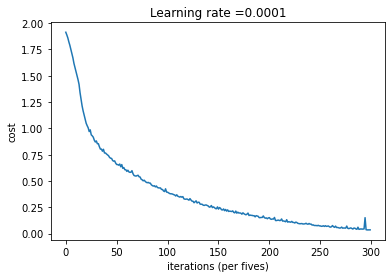

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [17]:
#lets train our model on our dataset and get train and test accuracy
parameters = model(X_train, Y_train, X_test, Y_test)




## - Test with your own image 
 You can now take a picture of your hand and see the output of your model. To do that:
    1. Add your image to the directory, in the "images" folder
    2. Write your image's name in the following code
    3. Run the code and check if the algorithm is right!

Your algorithm predicts: y = 4


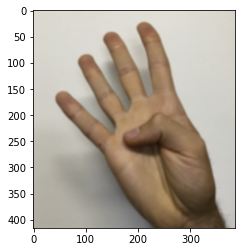

In [215]:
import matplotlib.image as mpimg 
import cv2
# img=cv2.imread('images/my_img1.png') 
img = mpimg.imread('images/my_img1.png') # my image is 4 channel image. So needed to convert it into 3 channels
image=cv2.resize(img,(64,64))
image=cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
image=cv2.cvtColor(image,cv2.COLOR_BGRA2BGR)
image=image.reshape(1,12288).T
image=image/255
my_image_prediction = predict(image, parameters)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

plt.imshow(img)

